In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"

# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr

In [2]:
# Read ICRF3 S/X catalog
icrf3_sx = Table.read("../data/icrf3sx.txt",
                      format="ascii.fixed_width", data_start=16,
                      names=["icrf_name", "iers_name_sx", "type_sx",
                             "ra_err_sx", "dec_err_sx", "ra_dec_corr_sx",
                             "mean_obs_sx", "beg_obs_sx", "end_obs_sx", "nb_sess_sx", "nb_del_sx"],
                      col_starts=[5, 25, 35, 83, 98,
                                  108, 118, 127, 136, 145, 150],
                      col_ends=[20, 32, 35, 92, 106, 114, 124, 133, 142, 148, 155])

# Position information
ra_dec = Table.read("../data/icrf3sx.txt",
                    format="ascii.fixed_width", data_start=16,
                    names=["ra_dec"], col_starts=[40], col_ends=[77])

ra_dec_sx = SkyCoord(ra_dec["ra_dec"], unit=(u.hourangle, u.deg))
ra_sx = Column(ra_dec_sx.ra, name="ra_sx")
dec_sx = Column(ra_dec_sx.dec, name="dec_sx")

# Add source position to the table
icrf3_sx.add_columns([ra_sx, dec_sx], indexes=[3, 3])

# Add unit information
icrf3_sx["ra_err_sx"] = icrf3_sx["ra_err_sx"] * 15e3 * np.cos(ra_dec_sx.dec.rad)
icrf3_sx["ra_err_sx"].unit = u.mas
icrf3_sx["dec_err_sx"].unit = u.arcsec
icrf3_sx["dec_err_sx"] = icrf3_sx["dec_err_sx"].to(u.mas)

# Calculate the semi-major axis of error ellipse
pos_err_sx = pos_err_calc(icrf3_sx["ra_err_sx"], icrf3_sx["dec_err_sx"], icrf3_sx["ra_dec_corr_sx"])

# Add the semi-major axis of error ellipse to the table
icrf3_sx.add_column(pos_err_sx, name="pos_err_sx", index=9)


In [3]:
# Read ICRF3 X/Ka catalog
icrf3_xka = Table.read("../data/icrf3xka.txt",
                       format="ascii.fixed_width", data_start=16,
                       names=["icrf_name", "iers_name_xka", "type_xka",
                              "ra_err_xka", "dec_err_xka", "ra_dec_corr_xka",
                              "mean_obs_xka", "beg_obs_xka", "end_obs_xka", "nb_sess_xka", "nb_del_xka"],
                       col_starts=[5, 25, 35, 83, 98,
                                   108, 118, 127, 136, 145, 150],
                       col_ends=[20, 32, 35, 92, 106, 114, 124, 133, 142, 148, 155])

# Position information
ra_dec = Table.read("../data/icrf3xka.txt",
                    format="ascii.fixed_width", data_start=16,
                    names=["ra_dec"], col_starts=[40], col_ends=[77])

ra_dec_xka = SkyCoord(ra_dec["ra_dec"], unit=(u.hourangle, u.deg))
ra_xka = Column(ra_dec_xka.ra, name="ra_xka")
dec_xka = Column(ra_dec_xka.dec, name="dec_xka")

# Add source position to the table
icrf3_xka.add_columns([ra_xka, dec_xka], indexes=[3, 3])

# Add unit information
icrf3_xka["ra_err_xka"] = icrf3_xka["ra_err_xka"] * \
    15e3 * np.cos(ra_dec_xka.dec.rad)
icrf3_xka["ra_err_xka"].unit = u.mas
icrf3_xka["dec_err_xka"].unit = u.arcsec
icrf3_xka["dec_err_xka"] = icrf3_xka["dec_err_xka"].to(u.mas)

# Calculate the semi-major axis of error ellipse
pos_err_xka = pos_err_calc(icrf3_xka["ra_err_xka"], icrf3_xka["dec_err_xka"], icrf3_xka["ra_dec_corr_xka"])

# Add the semi-major axis of error ellipse to the table
icrf3_xka.add_column(pos_err_xka, name="pos_err_xka", index=9)
icrf3_xka["pos_err_xka"].unit = u.mas

In [4]:
# Crossmatch.
sx_xka_com = join(icrf3_sx, icrf3_xka, keys="icrf_name", table_names=["sx", "xka"]) 

There are 793 common sources between S/X and K catalogs.

In [5]:
# The positonal offset for common sources between S/X and X/Ka (XKa - SX).
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov,
 ang_sep, X_a, X_d, X] = pos_diff_calc(
    sx_xka_com["ra_xka"], sx_xka_com["ra_err_xka"], sx_xka_com["dec_xka"], sx_xka_com["dec_err_xka"], sx_xka_com["ra_dec_corr_xka"],
    sx_xka_com["ra_sx"], sx_xka_com["ra_err_sx"], sx_xka_com["dec_sx"], sx_xka_com["dec_err_sx"], sx_xka_com["ra_dec_corr_sx"])

sx_xka_com.add_columns([dRA, dRA_err, dDC, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
                     names=["dra", "dra_err", "ddec", "ddec_err", "dra_ddec_cov",
                           "ang_sep", "nor_dra",  "nor_ddec", "nor_sep_cov"])

sx_xka_com["dra"].unit = u.mas
sx_xka_com["ddec"].unit = u.mas
sx_xka_com["dra_err"].unit = u.mas
sx_xka_com["ddec_err"].unit = u.mas
sx_xka_com["dra_ddec_cov"].unit = u.mas * u.mas
sx_xka_com

icrf_name,iers_name_sx,type_sx,ra_sx,dec_sx,ra_err_sx,dec_err_sx,ra_dec_corr_sx,mean_obs_sx,pos_err_sx,beg_obs_sx,end_obs_sx,nb_sess_sx,nb_del_sx,iers_name_xka,type_xka,ra_xka,dec_xka,ra_err_xka,dec_err_xka,ra_dec_corr_xka,mean_obs_xka,pos_err_xka,beg_obs_xka,end_obs_xka,nb_sess_xka,nb_del_xka,dra,dra_err,ddec,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep_cov
,,,deg,deg,mas,mas,,,,,,,,,,deg,deg,mas,mas,,,mas,,,,,mas,mas,mas,mas,mas2,deg,deg,deg,deg
str16,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J000435.6-473619,0002-478,D,1.1485645219166665,-47.60544555705556,0.06624331361080132,0.10759999999999999,0.2307,55601.6,0.1092520311826254,49330.5,58024.8,62,443,0002-478,D,1.1485644423333332,-47.60544576569445,0.13552067157926384,0.15839999999999999,-0.4333,57086.5,0.17781648296586014,56297.6,58027.3,23,30,-0.19316752422933284,0.15084438678132397,-0.7510999950000041,0.1914897386284706,-0.007657044376433456,0.7755416783809211,-1.2805748251631255,-3.922403364168209,4.601760261720644
J000504.3+542824,0002+541,--,1.2681806087916665,54.47359013780556,0.09605221846642922,0.10749999999999998,-0.0918,55527.4,0.1090556354174522,49577.0,57840.3,4,269,0002+541,--,1.268180768958333,54.47359004538889,0.09003805980033948,0.1306,0.1878,57364.8,0.13255795927164774,55304.5,58146.7,27,54,0.3350496628463878,0.1316543994135105,-0.3327000115405099,0.1691526233908301,0.0012604433626078335,0.4721732460152031,2.5449180911458753,-1.966862853624213,3.308600763295897
J000557.1+382015,0003+380,--,1.4882307787916664,38.33754137886111,0.04647392902187471,0.050899999999999994,-0.1368,52448.6,0.05257476533169057,48720.9,57103.0,29,1778,0003+380,--,1.488230883375,38.33754131888889,0.05988665795370894,0.08139999999999999,-0.3088,56844.3,0.08511922253959626,53561.7,58146.9,88,126,0.29531534729595704,0.0758039436942088,-0.21590000187643454,0.09600401033290222,-0.0018289337427057693,0.3658195800647857,3.8957781469424826,-2.2488644081406868,4.1107399707139765
J000613.8-062335,0003-066,--,1.5578870200833332,-6.393148710666667,0.030558773168077865,0.0314,-0.0235,53974.4,0.03153349547988754,47176.5,58205.8,1729,41822,0003-066,--,1.5578869827083333,-6.393148639388889,0.09346512575149064,0.12929999999999997,-0.5731,56545.8,0.14394735046495033,53561.6,58146.8,92,137,-0.13371326596928376,0.0983339633559026,0.256599998849083,0.1330580700295927,-0.006948486178086305,0.28934891896380366,-1.3597872129422055,1.9284812923561425,1.9687430995597859
J000903.9+062821,0006+061,--,2.2663826755416663,6.472566729833334,0.10477785575110041,0.19489999999999996,0.0741,55830.6,0.1951167069007926,52409.7,57407.7,4,295,0006+061,--,2.266382655708333,6.47256664575,0.09225816887728226,0.119,-0.6048,56785.3,0.13620602079885977,53651.5,58146.8,77,110,-0.07094489189970632,0.1396064782894674,-0.3027000026634141,0.22835719826622497,-0.005126719901136247,0.3109026685300272,-0.5081776488380823,-1.3255548980353065,1.513685975710927
J001031.0+105829,0007+106,D,2.6291912672083333,10.974862305027777,0.03607787203439982,0.0385,-0.0921,55813.0,0.039351348789675895,47288.7,58144.4,90,4042,0007+106,D,2.629191267708333,10.974862303833333,0.05522123270593726,0.08829999999999999,-0.4731,56132.3,0.09345139236115027,53694.3,58146.9,113,179,0.001767078023316971,0.06596209056794519,-0.004299997158341284,0.09632829283237608,-0.002434778809110875,0.004648928941404991,0.026789296823404453,-0.04463898437215996,0.04585371416701023
J001101.2-261233,0008-264,--,2.755194738583333,-26.209271426111112,0.03431739949162355,0.036,-0.1776,57115.3,0.03826341478939687,47686.1,58204.3,377,6779,0008-264,--,2.755194709333333,-26.209271528888888,0.12192770161551496,0.1281,-0.7062,56815.1,0.16338616394166613,53561.7,58111.2,66,114,-0.0944737826914959,0.12666510304385234,-0.36999999224462954,0.13306242895723794,-0.011249

In [6]:
std_ra = np.std(X_a)
std_dec = np.std(X_d)

std_ra, std_dec

(2.447140338374205, 2.0603014846007786)

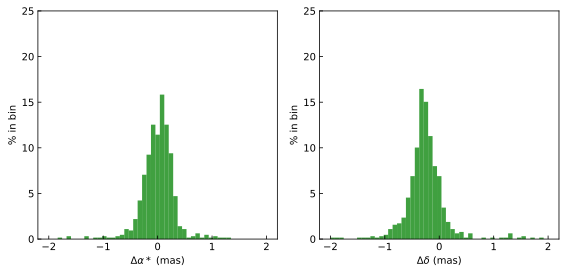

In [7]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 30, 5))
ax1.set_yticks(np.arange(0, 30, 5))

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

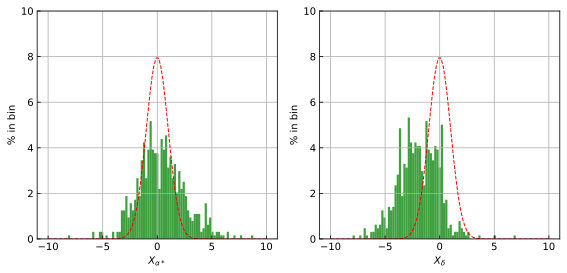

In [8]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.grid()
ax1.grid()

fig.tight_layout()
# plt.show()

plt.savefig("../plots/icrf3_sx_xka_nor_off.png")

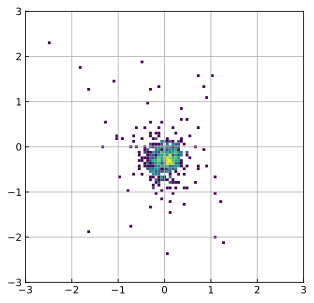

In [9]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-3, 3, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())
ax.grid(True)

plt.show()

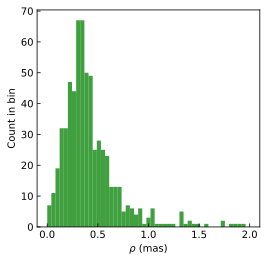

In [10]:
# Distribution of angular separation
bins_array = np.linspace(0, 2, 50)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

plt.show()

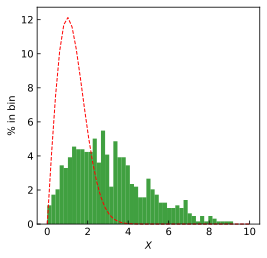

In [11]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

In [12]:
# Divide sources into 'Defining'  and 'Others'
mask = (sx_xka_com["type_sx"] == "D")
sx_xka_com_def = sx_xka_com[mask]

mask = (sx_xka_com["type_sx"] != "D")
sx_xka_com_oth = sx_xka_com[mask]

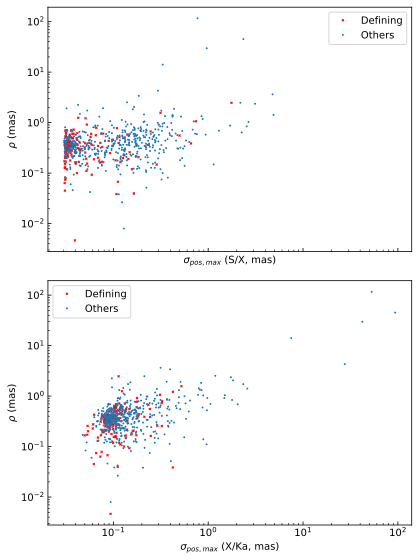

In [13]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(sx_xka_com_def["pos_err_sx"],
         sx_xka_com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(sx_xka_com_def["pos_err_xka"],
         sx_xka_com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(sx_xka_com_oth["pos_err_sx"],
         sx_xka_com_oth["ang_sep"], ".", ms=2, label="Others")
ax1.plot(sx_xka_com_oth["pos_err_xka"],
         sx_xka_com_oth["ang_sep"], ".", ms=2, label="Others")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (S/X, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (X/Ka, mas)")
ax1.set_ylabel("$\\rho$ (mas)")

ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

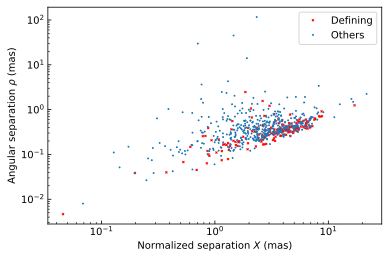

In [14]:
# Angular separation vs. Normalized separation
fig, ax = plt.subplots()
# figsize=(6, 8)

ax.plot(sx_xka_com_def["nor_sep_cov"],
         sx_xka_com_def["ang_sep"], "rx", ms=2, label="Defining")
ax.plot(sx_xka_com_oth["nor_sep_cov"],
         sx_xka_com_oth["ang_sep"], ".", ms=2, label="Others")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Normalized separation $X$ (mas)")
ax.set_ylabel("Angular separation $\\rho$ (mas)")

ax.legend()

plt.show()

In [15]:
# Remove the outlier (do not consider the normalized separation)
N = len(sx_xka_com)

print("There are %d sources.\n"
      "When angular separation >= 10 mas, the number of the outlier is smaller than 1." % N)

mask = ((sx_xka_com["ang_sep"] < 10) & 
        (sx_xka_com["pos_err_sx"] < 10) & 
        (sx_xka_com["pos_err_xka"] < 10))

# Table of a clean sample
sx_xka_clean = sx_xka_com[mask]

print("After elimination, there are %d sources in the clean sample" % len(sx_xka_clean))

There are 638 sources.
When angular separation >= 10 mas, the number of the outlier is smaller than 1.
After elimination, there are 633 sources in the clean sample


In [16]:
# Transform column into np.array
dra1 = np.array(sx_xka_clean["dra"])
ddec1 = np.array(sx_xka_clean["ddec"])
dra_err1 = np.array(sx_xka_clean["dra_err"])
ddec_err1 = np.array(sx_xka_clean["ddec_err"])
ra_rad1 = np.array(sx_xka_clean["ra_sx"].to(u.radian))
dec_rad1 = np.array(sx_xka_clean["dec_sx"].to(u.radian))
dra_ddec_cov1 = np.array(sx_xka_clean["dra_ddec_cov"])

In [17]:
# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1,
    cov=dra_ddec_cov1, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1,
    cov=dra_ddec_cov1, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra1.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (   633 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1    -6 +/-  13    -6 +/-  13   +67 +/-   9      +4 +/-  10   +45 +/-  10  -347 +/-  13
l_max=2   -27 +/-  11    -2 +/-  11   +17 +/-   7      +7 +/-  10   +35 +/-  10  -354 +/-  11
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -3     5
            EI22        5     5
            ER21      -33    12
            EI21       28    13
             E20       86    13
            MR22       -1     6
            MI22       10     6
            MR21       -7    11
     

I will re-estimate the 16 transformation parameters from the residuals.

In [18]:
# Remove the outlier (consider the normalized separation)
X0 = np.sqrt(np.log(N) * 2)

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((sx_xka_com["nor_sep_cov"] <= X0)
        & (sx_xka_com["ang_sep"] < 10)
        & (sx_xka_com["pos_err_sx"] < 10)
        & (sx_xka_com["pos_err_xka"] < 10))

# Table of a clean sample
sx_xka_clean = sx_xka_com[mask]

print("After elimination, there are %d sources in the clean sample" % len(sx_xka_clean))

There are 638 sources.
When X >= 3.59, the number of the outlier is smaller than 1.
After elimination, there are 401 sources in the clean sample


In [19]:
# Transform column into np.array
dra2 = np.array(sx_xka_clean["dra"])
ddec2 = np.array(sx_xka_clean["ddec"])
dra_err2 = np.array(sx_xka_clean["dra_err"])
ddec_err2 = np.array(sx_xka_clean["ddec_err"])
ra_rad2 = np.array(sx_xka_clean["ra_sx"].to(u.radian))
dec_rad2 = np.array(sx_xka_clean["dec_sx"].to(u.radian))
dra_ddec_cov2 = np.array(sx_xka_clean["dra_ddec_cov"])

In [20]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra2, ddec2, ra_rad2, dec_rad2, dra_err2, ddec_err2,
    cov=dra_ddec_cov2, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra2, ddec2, ra_rad2, dec_rad2, dra_err2, ddec_err2,
    cov=dra_ddec_cov2, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra1.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

Estimates (   633 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   -16 +/-  11    -3 +/-  10   +46 +/-   7      -3 +/-   9    +9 +/-   8  -229 +/-  11
l_max=2   -20 +/-  10    -5 +/-   9    +4 +/-   7      +4 +/-   8   +29 +/-   8  -253 +/-  10
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -3     4
            EI22        3     4
            ER21      -13    10
            EI21       23    10
             E20       60    13
            MR22       -1     6
            MI22        4     6
            MR21        2     9
     

In [21]:
# Remove the systematics
RA = np.array(sx_xka_com["ra_sx"].to(u.radian))
DE = np.array(sx_xka_com["dec_sx"].to(u.radian))

# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)
dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)

In [22]:
# Now recalculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

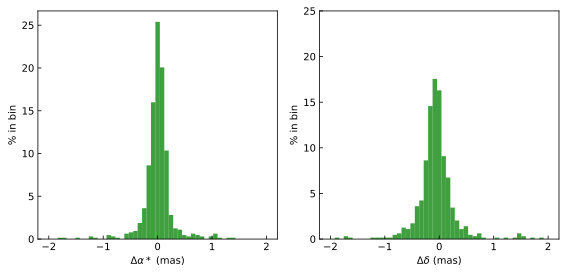

In [23]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 30, 5))
ax1.set_yticks(np.arange(0, 30, 5))

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

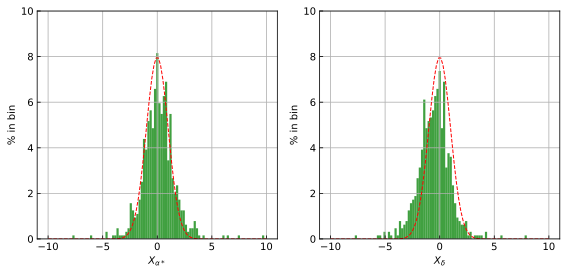

In [24]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.grid()
ax1.grid()

fig.tight_layout()
plt.show()

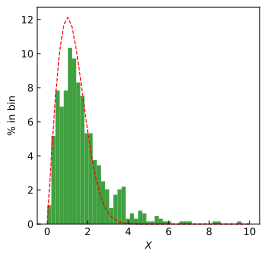

In [25]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

The last step is to save the 16 transformation parameters for further use.

In [26]:
# The 16-parameter estimated using all the sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2_all*1e3, sig2_all*1e3], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3_sx_xka_vsh02_all.log", format="ascii", overwrite=True)

# The 16-parameter estimated using a clean sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3_sx_xka_vsh02.log", format="ascii", overwrite=True)